<a href="https://colab.research.google.com/github/MehwishSayyed/Week3--Household-Energy-Consumption-Forecasting-System/blob/main/IntershipAssigments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install ucimlrepo




In [5]:
from ucimlrepo import fetch_ucirepo

dataset = fetch_ucirepo(id=235)

# Original data
df = dataset.data.original
df.isnull().sum()


/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,25979


In [6]:
# =============================
# 1. IMPORT LIBRARIES
# =============================
import pandas as pd
import numpy as np
from scipy import stats
from ucimlrepo import fetch_ucirepo   # to fetch the dataset directly

# =============================
# 2. LOAD DATASET
# =============================
# Fetch the "Individual household electric power consumption" dataset (ID 235)
dataset = fetch_ucirepo(id=235)

# Original data
df = dataset.data.original

# =============================
# 3. INITIAL INSPECTION
# =============================
print("Original dataset shape:", df.shape)
print("Columns available:", df.columns.tolist())
print(df.head())

# =============================
# 4. CLEANING PROCESS
# =============================

# Combine 'Date' and 'Time' columns into one datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')

# Drop the original Date and Time columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Set datetime as index
df.set_index('datetime', inplace=True)

# Replace '?' with NaN (since dataset uses '?' for missing values)
df.replace('?', np.nan, inplace=True)

# Convert all remaining columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# =============================
# 5. HANDLE MISSING VALUES
# =============================
# Interpolate missing values based on time
df = df.interpolate(method='time')

# Fill any remaining missing values (forward and backward)
df = df.ffill().bfill()

print("Total missing values after cleaning:", df.isnull().sum().sum())

# =============================
# 6. REMOVE OUTLIERS (OPTIONAL)
# =============================
# Remove rows with z-score > 3
z_scores = np.abs(stats.zscore(df))
df = df[(z_scores < 3).all(axis=1)]

# =============================
# 7. FINAL CHECK
# =============================
print("Cleaned dataset shape:", df.shape)
print(df.info())
print(df.head())


/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


Original dataset shape: (2075259, 9)
Columns available: ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000         

/tmp/ipython-input-3095581341.py:30: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')


Total missing values after cleaning: 0
Cleaned dataset shape: (1938923, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1938923 entries, 2006-12-16 17:38:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 118.3 MB
None
                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:38:00                4.054                  0.422   235.24   
2006-12-16 17:39:00                3.384                  0.282   237.14   
2006-12-16 17:40:00                3.270                  0.152   236.73   
2006-12-16 17:41:00          

In [7]:
# =============================
# 8. FEATURE ENGINEERING
# =============================

# Extract time-based features
df['hour'] = df.index.hour
df['weekday'] = df.index.dayofweek
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Rolling averages (3, 6, 12 intervals)
df['rolling_3'] = df['Global_active_power'].rolling(3).mean()
df['rolling_6'] = df['Global_active_power'].rolling(6).mean()
df['rolling_12'] = df['Global_active_power'].rolling(12).mean()

# Lag features (previous hour & previous day)
df['lag_1'] = df['Global_active_power'].shift(1)
df['lag_24'] = df['Global_active_power'].shift(24)

# Drop rows with NaN created by rolling/lag
df = df.dropna()

print("Dataset shape after feature engineering:", df.shape)
df.head()


Dataset shape after feature engineering: (1938899, 15)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,weekday,is_weekend,rolling_3,rolling_6,rolling_12,lag_1,lag_24
datetime,,,,,,,,,,,,,,,
2006-12-16 18:20:00,2.928,0.0,235.25,12.4,0.0,1.0,17.0,18,5,1,3.327333,2.961333,3.018667,2.852,4.054
2006-12-16 18:21:00,2.940,0.0,236.04,12.4,0.0,2.0,17.0,18,5,1,2.906667,2.936333,2.925500,2.928,3.384
2006-12-16 18:22:00,2.934,0.0,235.51,12.4,0.0,1.0,17.0,18,5,1,2.934000,3.040667,2.964000,2.940,3.270
2006-12-16 18:23:00,2.926,0.0,235.68,12.4,0.0,1.0,17.0,18,5,1,2.933333,3.130333,2.975333,2.934,3.430
2006-12-16 18:24:00,3.452,0.0,235.20,15.2,0.0,1.0,17.0,18,5,1,3.104000,3.005333,3.044333,2.926,3.266


In [7]:
from google.colab import files

# Save the cleaned dataset as a compressed .gz file
df.to_csv("cleaned_household_power_consumption.csv.gz", index=False, compression='gzip')

# Optional: check file size before download
import os
print("Compressed file size:", round(os.path.getsize("cleaned_household_power_consumption.csv.gz") / (1024*1024), 2), "MB")

# Download the compressed file
# files.download("cleaned_household_power_consumption.csv.gz")


Compressed file size: 11.79 MB


In [8]:
# Convert index to datetime (if not already)
df.index = pd.to_datetime(df.index)

# Sort by datetime index
df = df.sort_index()

print(df.index[:5])   # preview


DatetimeIndex(['2006-12-16 17:38:00', '2006-12-16 17:39:00',
               '2006-12-16 17:40:00', '2006-12-16 17:41:00',
               '2006-12-16 17:42:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)


week 2


global active column will be my output

In [9]:
# Define features and target

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x = df.drop(columns=['Global_active_power'])
y = df['Global_active_power']


#spliting the data

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# 80 % for training
# 20 % for testing

# create train model

model = RandomForestRegressor(
    n_estimators=100,    # number of trees
    random_state=42,
    n_jobs=-1            # use all cores for faster training

)

model.fit(x_train, y_train)

#prediction

y_pred = model.predict(x_test)

# Evaluate performance

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R² Score:", r2)


Mean Absolute Error: 0.017675401983991524
Mean Squared Error: 0.0009813363793624596
R² Score: 0.9984084871021275


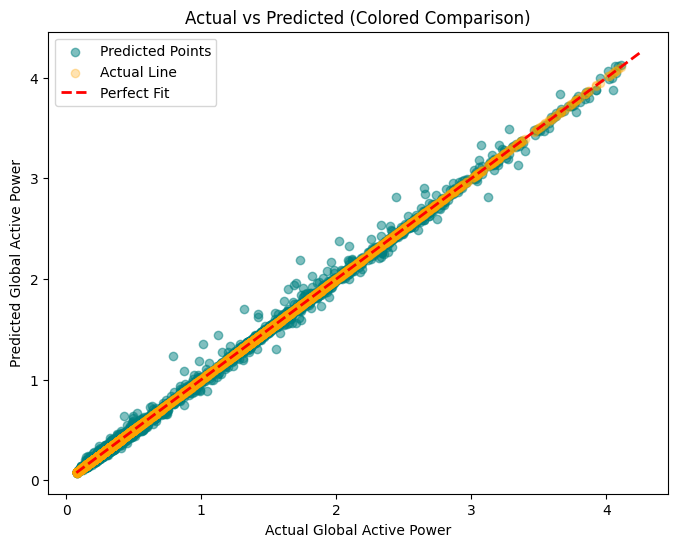

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Actual vs Predicted points (different colors)
plt.scatter(y_test[:5000], y_pred[:5000], color='teal', alpha=0.5, label='Predicted Points')
plt.scatter(y_test[:5000], y_test[:5000], color='orange', alpha=0.3, label='Actual Line')

# Perfect prediction diagonal
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')

plt.xlabel("Actual Global Active Power")
plt.ylabel("Predicted Global Active Power")
plt.title("Actual vs Predicted (Colored Comparison)")
plt.legend()
plt.show()


In [12]:
# numeric accuracy
# Calculate percentage accuracy
accuracy = 100 * (1 - (abs(y_test - y_pred) / y_test).mean())
print(f"Average Prediction Accuracy: {accuracy:.2f}%")


Average Prediction Accuracy: 96.68%


In [13]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
accuracy = 100 - mape

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Average Prediction Accuracy: {accuracy:.2f}%")


Mean Absolute Percentage Error (MAPE): 3.32%
Average Prediction Accuracy: 96.68%


In [14]:
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Prediction': y_pred
})

# Drop rows with very small or zero actual values
comparison = comparison[comparison['Actual'] > 0.1]

# Calculate per-row accuracy safely
comparison['Accuracy (%)'] = 100 * (1 - abs(comparison['Actual'] - comparison['Prediction']) / comparison['Actual'])
comparison['Accuracy (%)'] = comparison['Accuracy (%)'].clip(lower=0, upper=100)  # avoid negative or over 100%

print(comparison.head(10))
print(f"\nAverage Accuracy: {comparison['Accuracy (%)'].mean():.2f}%")
print(f"Minimum Accuracy: {comparison['Accuracy (%)'].min():.2f}%")
print(f"Maximum Accuracy: {comparison['Accuracy (%)'].max():.2f}%")


     Actual  Prediction  Accuracy (%)
0  0.370000    0.412033     88.639640
1  0.306000    0.291016     95.103268
2  0.324000    0.334030     96.904321
3  0.500000    0.492580     98.516000
4  0.220000    0.203347     92.430455
5  0.291624    0.291626     99.999282
6  0.688000    0.698140     98.526163
7  2.086000    2.047300     98.144775
8  0.358000    0.377117     94.660149
9  1.744000    1.717300     98.469037

Average Accuracy: 96.67%
Minimum Accuracy: 0.00%
Maximum Accuracy: 100.00%


In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Global_active_power'])
y = df['Global_active_power']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [15]:
rf = RandomForestRegressor(
    n_estimators=40,
    max_depth=10,
    min_samples_split=10,
    n_jobs=-1,
    random_state=42
)

rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)


In [16]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_test)


In [17]:
from sklearn.metrics import *
from sklearn.metrics import mean_absolute_percentage_error

# Random Forest
print("RF MAPE:", mean_absolute_percentage_error(y_test, y_pred_rf)*100)
print("RF MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RF R2:", r2_score(y_test, y_pred_rf))

# XGBoost
print("XGB MAPE:", mean_absolute_percentage_error(y_test, y_pred_xgb)*100)
print("XGB MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGB R2:", r2_score(y_test, y_pred_xgb))


RF MAPE: 2.114498483418769
RF MAE: 0.013817458782102072
RF R2: 0.9985545773089256
XGB MAPE: 2.3156249045456465
XGB MAE: 0.013611867387662138
XGB R2: 0.998927603324032


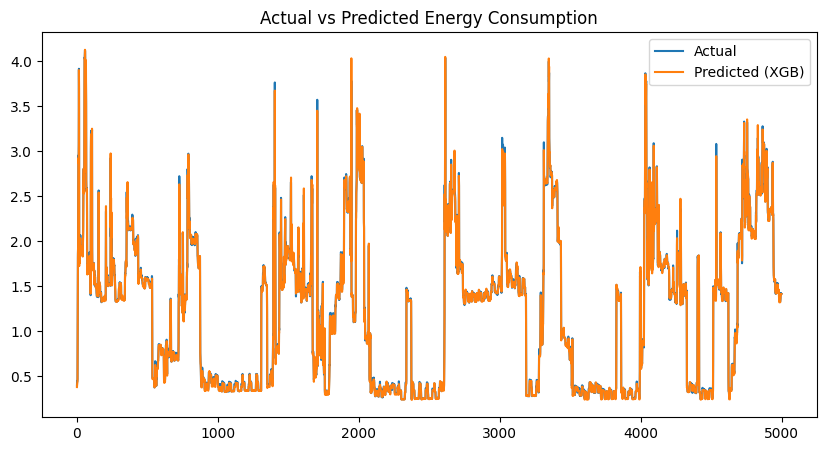

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values[:5000], label="Actual")
plt.plot(y_pred_xgb[:5000], label="Predicted (XGB)")
plt.legend()
plt.title("Actual vs Predicted Energy Consumption")
plt.show()
